# Project Overview

The purpose of this project was to analyze how different factors like school crime, health, and income affect SAT performance across public schools in NYC. The analysis relies only upon open data sources and combined statistical testing with mapping techniques to show how these factors do affect student performance on the SAT.

## Setup

In [1]:
import numpy as np
import pandas as pd
import os
import urllib.request
import matplotlib.pylab as plt
import geopandas as gpd
import shapely
from fiona.crs import from_epsg
from geopandas.tools import sjoin
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.api import abline_plot
from sklearn.ensemble  import RandomForestRegressor as rfc
from sklearn.cross_validation import train_test_split
import seaborn as sns
import ast

# Imports for SQL query
try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# For data storage
os.environ["PUIdata"] = "{}/PUIdata".format(os.getenv("HOME"))

# Part I - Data Gathering

## Collect school data

In [3]:
# SAT data
sat_url = 'https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD'
urllib.request.urlretrieve(sat_url, 'sat.csv')

('sat.csv', <http.client.HTTPMessage at 0x7fc69deb77f0>)

In [4]:
!mv sat.csv $PUIdata

In [5]:
sat = pd.read_csv(os.getenv("PUIdata") + '/sat.csv')
sat.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [6]:
sat.rename(columns={'SAT Math Avg. Score':'SATmath'}, inplace=True)

In [7]:
sat = sat[sat['SATmath'] != 's']

In [8]:
types_dict = {'Num of SAT Test Takers':int, 'SAT Critical Reading Avg. Score':int, 'SATmath':int, \
              'SAT Writing Avg. Score':int}
for col, col_type in types_dict.items():
    sat[col] = sat[col].astype(col_type)

In [9]:
sat['SATall'] = (sat['SAT Critical Reading Avg. Score'] + sat['SATmath'] + sat['SAT Writing Avg. Score'])/3

In [10]:
sat = sat[['DBN', 'SATmath', 'SATall']]
sat.head()

,DBN,SATmath,SATall
0,01M292,404,374.000000
1,01M448,423,390.666667
2,01M450,402,383.000000
3,01M458,401,391.333333
4,01M509,433,402.333333


### Crime

In [11]:
# Crime data
crime_url = 'https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD'

In [12]:
urllib.request.urlretrieve(crime_url, 'crime.csv')

('crime.csv', <http.client.HTTPMessage at 0x7fc6a27fe358>)

In [13]:
!mv crime.csv $PUIdata

In [14]:
crime = pd.read_csv(os.getenv("PUIdata") + '/crime.csv')
crime.head()

,School Year,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,...,Borough Name,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,2015-16,K006,17K006,P.S. 006,K006,43 SNYDER AVENUE,K,17.0,712,NaN,...,BROOKLYN,11226.0,40.648590,-73.957138,14.0,40.0,794.0,3117230.0,3.051030e+09,Erasmus ...
1,2015-16,K005,16K005,P.S. 005 Dr. Ronald Mcnair,K005,820 HANCOCK STREET,K,16.0,231,NaN,...,BROOKLYN,11233.0,40.685695,-73.922463,3.0,41.0,377.0,3039906.0,3.014900e+09,Stuyvesant Heights ...
2,2015-16,K003,13K003,P.S. 003 The Bedford Village,K003,50 JEFFERSON AVENUE,K,13.0,450,NaN,...,BROOKLYN,11216.0,40.682663,-73.955338,3.0,36.0,227.0,3057406.0,3.019980e+09,Clinton Hill ...
3,2015-16,K002,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,NaN,655 PARKSIDE AVENUE,K,17.0,1378,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
4,2015-16,K002,75K141,P.S. K141,K141,655 PARKSIDE AVENUE,K,17.0,374,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...


In [15]:
col_keep = ['DBN','Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', \
            'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'Latitude', 'Longitude']

In [16]:
crime = crime[col_keep]

In [17]:
# Fill nans with zeros for ease of dataframe manipulation
crime.fillna(value=0, inplace=True)

In [18]:
# I take the mean crime statistics across years for an esimate of crime in 2012
crime = crime.groupby(['DBN','Latitude', 'Longitude']).mean()[['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', \
        'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N']]

In [19]:
crime = crime.reset_index()

In [20]:
crime['DBN'] = crime['DBN'].astype(str)

In [21]:
crime.DBN = crime.DBN.str.rstrip()

In [22]:
crime.head()

,DBN,Latitude,Longitude,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N
0,0,0.000000,0.000000,3.500000,8.500000,17.500000,4.500000,5.500000,1.360000,4.605000,7.715000,3.025,2.265000
1,0,40.508809,-74.222403,1.333333,4.666667,34.333333,0.666667,4.333333,0.460000,1.876667,3.030000,1.170,0.880000
2,0,40.528092,-74.192032,0.666667,14.333333,28.000000,8.000000,5.000000,1.843333,8.890000,12.576667,6.400,2.556667
3,0,40.569393,-74.107737,2.333333,13.000000,34.666667,7.666667,5.000000,3.133333,12.443333,33.630000,7.060,5.863333
4,0,40.577520,-73.969517,0.000000,0.000000,0.333333,0.000000,0.000000,0.286667,0.960000,1.393333,0.680,0.433333


## Merge crime and SAT data

In [23]:
# Right merge since schools with no crime data weren't reported but actually had zero crimes
schools = crime.merge(sat, on='DBN', how='right')

In [24]:
# For those schools with no crimes that were added to the df because of SAT scores, fill nans with zeros
schools.fillna(value=0, inplace=True)

In [25]:
schools.head()

,DBN,Latitude,Longitude,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall
0,01M292,40.713684,-73.986336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,404,374.000000
1,01M448,40.712399,-73.984497,0.333333,1.333333,3.000000,0.666667,0.333333,0.296667,1.023333,1.380000,0.72,0.473333,423,390.666667
2,01M450,40.729589,-73.982555,0.333333,3.333333,0.666667,2.000000,0.666667,0.306667,1.183333,1.773333,0.79,0.543333,402,383.000000
3,01M458,40.722520,-73.990728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,401,391.333333
4,01M509,40.720581,-73.985645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,433,402.333333


## 3. Visualize the school data

### Plot of SAT scores against crime

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


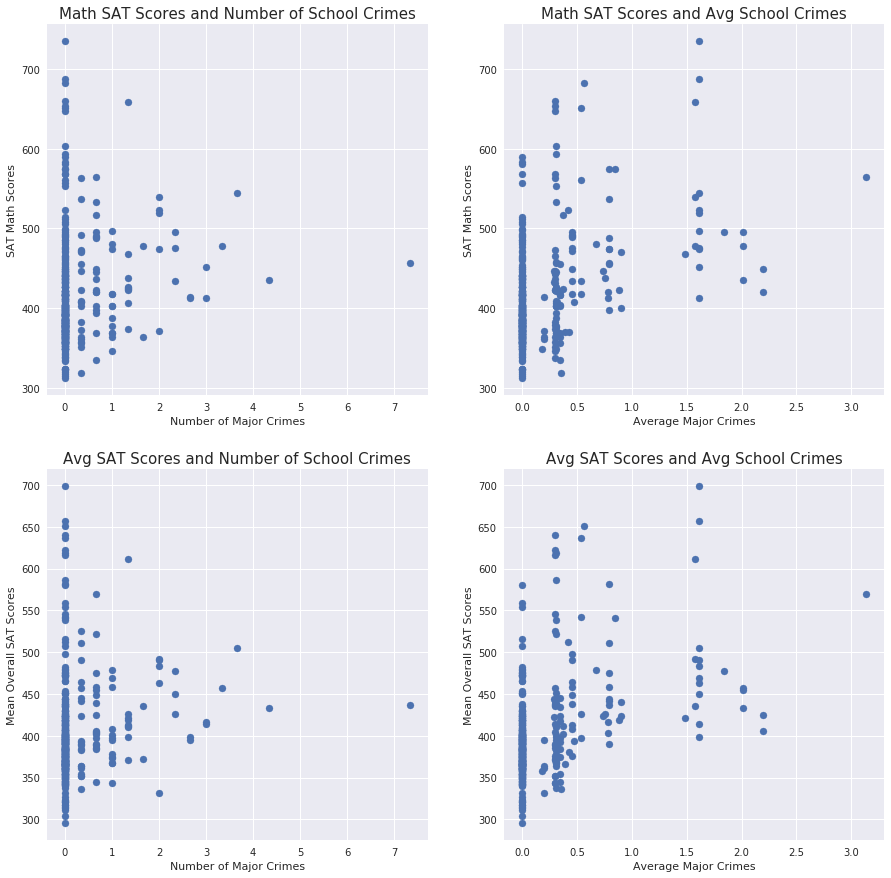

In [26]:
fig = plt.figure(figsize=(15,15)) 

ax1 = fig.add_subplot(221)
scatter = ax1.scatter(schools['Major N'], schools['SATmath'])
ax1.set_xlabel("Number of Major Crimes")
ax1.set_ylabel("SAT Math Scores")
ax1.set_title("Math SAT Scores and Number of School Crimes", fontsize=15)

ax2 = fig.add_subplot(222)
scatter = ax2.scatter(schools['AvgOfMajor N'], schools['SATmath'])
ax2.set_xlabel("Average Major Crimes")
ax2.set_ylabel("SAT Math Scores")
ax2.set_title("Math SAT Scores and Avg School Crimes", fontsize=15)

ax3 = fig.add_subplot(223)
scatter = ax3.scatter(schools['Major N'], schools['SATall'])
ax3.set_xlabel("Number of Major Crimes")
ax3.set_ylabel("Mean Overall SAT Scores")
ax3.set_title("Avg SAT Scores and Number of School Crimes", fontsize=15)

ax4 = fig.add_subplot(224)
scatter = ax4.scatter(schools['AvgOfMajor N'], schools['SATall'])
ax4.set_xlabel("Average Major Crimes")
ax4.set_ylabel("Mean Overall SAT Scores")
ax4.set_title("Avg SAT Scores and Avg School Crimes", fontsize=15)

plt.show()

### Note on above plots:

The above plots show SAT Math and mean SAT scores across reading, writing and math sections as a function of the number of major crimes and average number of major crimes at each school. Note that the crime rates are the means for each school over time.

Based on a visual assessment of the plots, alone, it appears there may be no correlation between SAT scores and the number of major crimes committed at schools and possibly a slightly positive correlation between SAT scores and the average number of major crimes. This second observation is a surprising one since one might assume that more crime generally takes place in lower-performing schools. Larger schools will presumably have more crimes committed. This plot therefore leads me to wonder if students at larger schools in NYC generally perform better on the SAT than students at smaller schools, which may be a product of increased competition.

### Create lat long geometry for all schools

In [27]:
schools['lonlat'] = list(zip(schools.Longitude, schools.Latitude))
schools['geometry'] = schools[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
schools_gdf = gpd.GeoDataFrame(schools)
schools_gdf.crs = from_epsg(4326)

In [28]:
# After plotting data, noticed that two school locations had lat and long values of 0, which skewed plot
# Removed those two rows with the following, leaving 412 school/SAT observations
schools_gdf = schools_gdf[(schools_gdf['Latitude'] != 0)]
schools_gdf.shape

(413, 17)

In [29]:
schools_gdf.drop(['Latitude', 'Longitude', 'lonlat'], axis=1, inplace=True)
schools_gdf.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,geometry
0,01M292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,404,374.000000,POINT (-73.98633599999999 40.713684)
1,01M448,0.333333,1.333333,3.000000,0.666667,0.333333,0.296667,1.023333,1.380000,0.72,0.473333,423,390.666667,POINT (-73.98449699999999 40.712399)
2,01M450,0.333333,3.333333,0.666667,2.000000,0.666667,0.306667,1.183333,1.773333,0.79,0.543333,402,383.000000,POINT (-73.982555 40.729589)
3,01M458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,401,391.333333,POINT (-73.990728 40.72252)
4,01M509,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,433,402.333333,POINT (-73.98564499999999 40.720581)


## Gather hospital discharge data

### Read in SPARCS data

In [30]:
# SPARCS contains hospital discharge data that is anonymized
sparcs_url = 'https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD'
urllib.request.urlretrieve(sparcs_url, 'sparcs.csv')

('sparcs.csv', <http.client.HTTPMessage at 0x7fc69d923940>)

In [31]:
!mv sparcs.csv $PUIdata

mv: cannot stat 'sparcs.csv': No such file or directory


In [32]:
sparcs = pd.read_csv(os.getenv("PUIdata") + '/sparcs.csv')
sparcs.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,5511.95,5582.49
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,4783.20,5162.82
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3829.15,4056.52
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,0 to 17,147,F,White,Not Span/Hispanic,...,NaN,NaN,182357.0,NaN,NaN,0,N,Y,1108.20,1644.75
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3418.18,3370.87


In [33]:
# Removing data not in NYC
sparcs = sparcs[(sparcs['Hospital County'] == 'Bronx') | (sparcs['Hospital County'] == 'Kings') | \
                (sparcs['Hospital County'] == 'Manhattan') | (sparcs['Hospital County'] == 'Queens') | \
                (sparcs['Hospital County'] == 'Richmond')]

### Calculate the fraction of asthma and drug-related diagnoses per facility

In [34]:
sparcs['asthma'] = (sparcs['CCS Diagnosis Description'] == 'Asthma') | \
    (sparcs['CCS Diagnosis Description'] == 'Respiratory failure; insufficiency; arrest (adult)') | \
    (sparcs['CCS Diagnosis Description'] == 'Respiratory distress syndrome')

In [35]:
sparcs['drugs'] = (sparcs['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents') | \
    (sparcs['CCS Diagnosis Description'] == 'Alcohol-related disorders') | \
    (sparcs['CCS Diagnosis Description'] == 'Substance-related disorders')

In [36]:
sparcs['total_discharge'] = 1

In [37]:
discharge = sparcs.groupby('Facility ID').sum().reset_index()
discharge.head()

,Facility ID,Operating Certificate Number,Discharge Year,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Total Charges,Total Costs,asthma,drugs,total_discharge
0,1164.0,3.441900e+10,9893004,3236230,969668,3739297,95623,8927,2.807878e+09,2.353652e+09,7.586577e+08,0,7.157508e+07,6.843559e+07,0.0,2389.0,4917
1,1165.0,1.466920e+11,42163472,4765391,2341986,9546521,239604,41843,2.238913e+10,1.483045e+10,NaN,6495200,4.214969e+08,3.489927e+08,1123.0,1279.0,20956
2,1168.0,1.112231e+11,31968668,3202865,2250304,7482827,186011,32066,3.147042e+09,2.896329e+09,1.919679e+09,8155000,7.013724e+08,1.678174e+08,580.0,1006.0,15889
3,1169.0,3.055503e+11,87823800,5870166,5332109,14021718,352583,95331,2.820312e+10,3.206590e+10,1.401884e+10,823300,2.741680e+09,6.360669e+08,2105.0,323.0,43650
4,1172.0,1.619942e+11,46561704,4126536,2644766,8974944,223716,41921,1.569414e+11,7.064387e+10,NaN,7656600,2.534645e+08,2.442128e+08,1826.0,611.0,23142


In [38]:
discharge['asthmaRatio'] = discharge['asthma'] / discharge['total_discharge']
discharge['drugsRatio'] = discharge['drugs'] / discharge['total_discharge']

In [39]:
nd = sparcs.shape[0]
print("Number of NYC discharges:", str(nd))

Number of NYC discharges: 1199520


In [40]:
nycF = discharge.shape[0]
print("Number of NYC facilities in the dataset:", nycF)

Number of NYC facilities in the dataset: 61


In [41]:
nyca = discharge['asthma'].sum()
print("Number of asthma related cases in NYC:", nyca) 

Number of asthma related cases in NYC: 30717.0


In [42]:
nycd = discharge['drugs'].sum()
print("Number of drug related cases in NYC:", nycd) 

Number of drug related cases in NYC: 46336.0


In [43]:
discharge = discharge[['Facility ID','asthmaRatio','drugsRatio']]

In [44]:
discharge.head()

,Facility ID,asthmaRatio,drugsRatio
0,1164.0,0.000000,0.485865
1,1165.0,0.053588,0.061033
2,1168.0,0.036503,0.063314
3,1169.0,0.048225,0.007400
4,1172.0,0.078904,0.026402


### Find the location of each facility

In [45]:
# The facility locations data was provided to us in a CartoDB database.
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql?q='

def queryDB(query, formatting = 'CSV', source = SQL_SOURCE):
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query):
    try:
        return pd.read_csv(io(queryDB(query)), sep = ',')
    except ValueError as v:
        print (str(v))

In [46]:
query = '''
SELECT * FROM fb55.nyc_facilities
'''
loc_query = get_data(query)
loc_query.head()

,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,facility_open_date,facility_address_1,facility_address_2,...,cooperator_name,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location
0,0101000020E6100000E40F069E7B7C52C05952EE3EC753...,Metropolitan Area Regional Office - New York City,0101000020110F000046B5633099665FC167AF70FB3AED...,1320,University Hospital of Brooklyn,HOSP,Hospital,01/01/1901,445 Lenox Road,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,State,40.654518,-73.945045,"(40.654518, -73.945045)"
1,0101000020E61000008BC058DFC07852C04BC8073D9B53...,Metropolitan Area Regional Office - New York City,0101000020110F00001F2C777543605FC14E668BB709ED...,6448,PALA Community Care,DTC,Diagnostic and Treatment Center,09/12/2002,1110 Pennsylvania Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.653175,-73.886772,"(40.653175, -73.886772)"
2,0101000020E6100000D3DC0A61357D52C09AFF571D3958...,Metropolitan Area Regional Office - New York City,0101000020110F00006ACD5FB9D4675FC19AEE7C2435F2...,6754,Medcare LLC,DTC,Diagnostic and Treatment Center,02/26/2007,468 Lafayette Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.689243,-73.956383,"(40.689243, -73.956383)"
3,0101000020E61000006DCA15DEE57952C08A027D224F6C...,Metropolitan Area Regional Office - New York City,0101000020110F00007164F52335625FC110A7A85CBB08...,1206,P R O M E S A Inc,DTC,Diagnostic and Treatment Center,09/27/1979,1776 Clay Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.846165,-73.904655,"(40.846165, -73.904655)"
4,0101000020E6100000D6C4025FD17A52C038BF61A24168...,Metropolitan Area Regional Office - New York City,0101000020110F00006301C42AC5635FC1A351F0D12E04...,1207,Narco Freedom Inc,DTC,Diagnostic and Treatment Center,09/27/1979,479 Willis Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.814503,-73.919029,"(40.814503, -73.919029)"


In [47]:
discharge.rename(columns={'Facility ID':'facility_id'}, inplace=True)

In [48]:
discharge = discharge.merge(loc_query[['facility_id','facility_latitude','facility_longitude']],\
                            on='facility_id', how='left')

In [49]:
discharge['lonlat'] = list(zip(discharge.facility_longitude, discharge.facility_latitude))
discharge['geometry'] = discharge[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
discharge_gdf = gpd.GeoDataFrame(discharge)
discharge_gdf.crs = from_epsg(4326)
discharge_gdf.head()

,facility_id,asthmaRatio,drugsRatio,facility_latitude,facility_longitude,lonlat,geometry
0,1164.0,0.000000,0.485865,40.831772,-73.903656,"(-73.903656, 40.831772)",POINT (-73.90365600000001 40.83177199999999)
1,1165.0,0.053588,0.061033,40.857388,-73.846741,"(-73.846741, 40.857388)",POINT (-73.84674100000001 40.857388)
2,1168.0,0.036503,0.063314,40.894569,-73.861420,"(-73.86142, 40.894569)",POINT (-73.86142 40.894569)
3,1169.0,0.048225,0.007400,40.879951,-73.880562,"(-73.880562, 40.879951)",POINT (-73.880562 40.879951)
4,1172.0,0.078904,0.026402,40.817661,-73.924210,"(-73.92421, 40.817661)",POINT (-73.92421 40.817661)


## Aggregate the data at the PUMA level

### Get the PUMA data

In [50]:
# Clear out any old versions of the NYC spatial data
!if [ -f file.gz ]; then rm -r file.gz; fi
!if [ $PUIDATA/puma ]; then rm -r $PUIDATA/puma; fi

In [51]:
# Download data
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?'\
                           + 'method=export&format=Shapefile', "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7fc6988b20f0>)

In [52]:
# Unzip to PUIData
!unzip file.gz -d $PUIdata/puma
!cd $PUIdata/puma

Archive:  file.gz
  inflating: /nfshome/shb395/PUIdata/puma/geo_export_d5bed193-b1ee-423a-b5bb-5e17a0b99a1f.dbf  
  inflating: /nfshome/shb395/PUIdata/puma/geo_export_d5bed193-b1ee-423a-b5bb-5e17a0b99a1f.shp  
  inflating: /nfshome/shb395/PUIdata/puma/geo_export_d5bed193-b1ee-423a-b5bb-5e17a0b99a1f.shx  
  inflating: /nfshome/shb395/PUIdata/puma/geo_export_d5bed193-b1ee-423a-b5bb-5e17a0b99a1f.prj  


In [53]:
# Get list of files in file.gz
files = !ls $PUIdata/puma
print(files)

['geo_export_d5bed193-b1ee-423a-b5bb-5e17a0b99a1f.dbf', 'geo_export_d5bed193-b1ee-423a-b5bb-5e17a0b99a1f.prj', 'geo_export_d5bed193-b1ee-423a-b5bb-5e17a0b99a1f.shp', 'geo_export_d5bed193-b1ee-423a-b5bb-5e17a0b99a1f.shx']


In [54]:
# Load the shapefile and convert puma column to ints for later merge
shp = files[2]
loc = os.environ["PUIdata"] + '/puma/' + shp
pumashp = gpd.GeoDataFrame.from_file(loc)
pumashp.rename(columns={'puma':'GeoID'}, inplace=True)
pumashp['GeoID'] = pumashp['GeoID'].astype('int')
pumashp.head()

,GeoID,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,2.670137e+08,304071.084143,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415288,POLYGON ((-73.95374853778468 40.63858633758547...


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


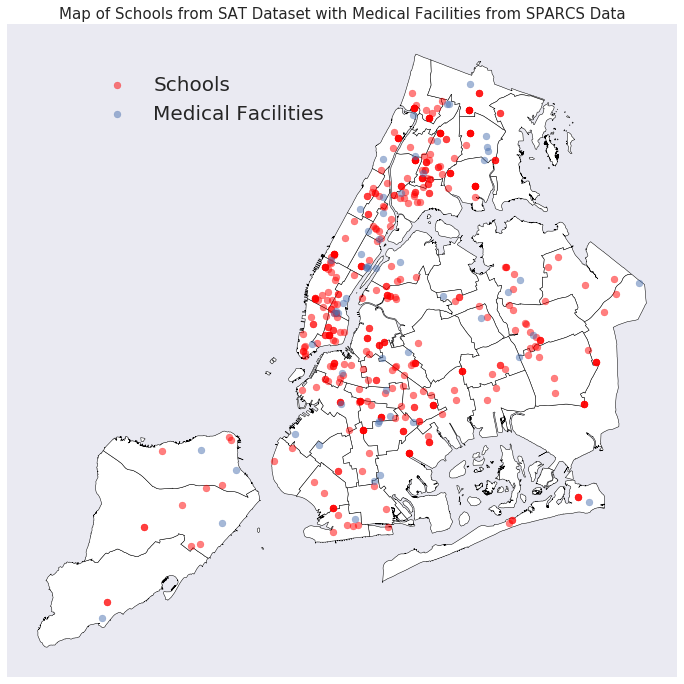

In [55]:
f, ax = plt.subplots(figsize=(12,12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashp.plot(alpha=1,linewidth=0.5,ax=ax,color='w',edgecolor='black')
schools_gdf.plot(alpha=.5, ax=ax, c='red', label='Schools')
discharge_gdf.plot(alpha=.5, ax=ax, label='Medical Facilities')
ax.legend(fontsize=20)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.5, 0.95, 0, 0))
plt.title("Map of Schools from SAT Dataset with Medical Facilities from SPARCS Data", fontsize=15)
plt.show()

### Note on above plot:

The above plot shows the location of each medical facility and school from the data used in this analysis. Schools clearly outnumber medical facilities, with a heavey concentration of schools in Manhattan, south Bronx, and north Brooklyn. Medical facilities appear to be more evenly distributed throughout the city although a more precise geospatial analysis would need to be performed to confirm this. Since the locations of medical facilities often overlap with schools, we can have greater confidence in correlations between the two factors.

### Join medical facilities data with PUMAs

In [56]:
# Received warning regarding crs to used to_crs to make sure systems matched
discharge_gdf.to_crs(epsg=4326, inplace=True)
schools_gdf.to_crs(epsg=4326, inplace=True)
pumashp.to_crs(epsg=4326, inplace=True)

In [57]:
pumashp_mj = gpd.sjoin(pumashp,discharge_gdf).groupby(['GeoID']).mean()[['asthmaRatio', 'drugsRatio']]
pumashp_mj.reset_index(inplace=True)
pumashp_mj.head()

,GeoID,asthmaRatio,drugsRatio
0,3702,0.036503,0.063314
1,3704,0.027440,0.021513
2,3705,0.022103,0.344390
3,3706,0.038256,0.013680
4,3707,0.054454,0.013583


### Join schools data with PUMAs

In [58]:
schools_gdf.drop(['DBN'], axis=1, inplace=True)

In [59]:
pumashp_sj = gpd.sjoin(pumashp,schools_gdf).groupby(['GeoID']).mean()[['Major N', 'Oth N', 'NoCrim N', 'Prop N', \
            'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'SATmath', 'SATall']]
pumashp_sj.reset_index(inplace=True)

In [60]:
alldata = pumashp_sj.merge(pumashp_mj, how='outer', on='GeoID')

In [61]:
alldata.head()

,GeoID,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthmaRatio,drugsRatio
0,3701.0,0.030303,0.818182,1.696970,0.454545,0.151515,0.288788,1.321515,2.244242,0.813939,0.544242,443.363636,430.363636,NaN,NaN
1,3702.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.036503,0.063314
2,3703.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.400000,391.400000,NaN,NaN
3,3704.0,0.000000,1.166667,0.722222,0.611111,0.444444,0.048333,0.185000,0.267222,0.125556,0.083889,412.666667,404.611111,0.027440,0.021513
4,3705.0,0.185185,0.987654,1.617284,0.432099,0.481481,0.056296,0.210617,0.312963,0.142222,0.096914,378.222222,373.629630,0.022103,0.344390


### Income data

I was unable to locate 5-year income data at the PUMA level specifically for 2012. Instead, I used ACS 5-year income data provided by the NYC Deparatment of Planning for 2016. The income data included in the 2016 report is the average of income data recorded between 2012 and 2016. I felt it was reasonable to use this data since it includes information captured in 2012 and because median income for a neighborhood is unlikely to change significantly in a period as short as 5 years. 

To acquire the data, simply run the following cells.

In [62]:
econ_url = 'https://www1.nyc.gov/assets/planning/download/office/data-maps/'\
'nyc-population/acs/econ_2016acs5yr_puma.xlsx?r=1'

In [63]:
urllib.request.urlretrieve(econ_url, "econ.xlsx")

('econ.xlsx', <http.client.HTTPMessage at 0x7fc6982c25f8>)

In [64]:
!mv econ.xlsx $PUIdata

In [65]:
acs_econ = pd.read_excel(os.getenv("PUIdata") + '/econ.xlsx')

In [66]:
acs_econ.head()

,GeoType,GeogName,GeoID,Borough,Pop16plE,Pop16plM,Pop16plC,Pop16plP,Pop16plZ,LFE,...,Pv400t499E,Pv400t499M,Pv400t499C,Pv400t499P,Pv400t499Z,Pv500plE,Pv500plM,Pv500plC,Pv500plP,Pv500plZ
0,PUMA2010,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,Bronx,88154,1676,1.2,100,NaN,55882,...,9086,796,5.3,8.7,0.7,31029,1357,2.7,29.7,1.2
1,PUMA2010,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,Bronx,114663,2138,1.1,100,NaN,73371,...,14282,951,4.0,10.0,0.6,27343,1297,2.9,19.1,0.8
2,PUMA2010,"NYC-Bronx Community District 10--Co-op City, P...",3703,Bronx,101891,2457,1.5,100,NaN,60153,...,13516,1244,5.6,11.4,1.0,36866,2061,3.4,31.1,1.6
3,PUMA2010,NYC-Bronx Community District 11--Pelham Parkwa...,3704,Bronx,103668,1893,1.1,100,NaN,64886,...,12233,837,4.2,9.7,0.6,24820,1101,2.7,19.7,0.8
4,PUMA2010,"NYC-Bronx Community District 3 & 6--Belmont, C...",3705,Bronx,127196,2165,1.0,100,NaN,70160,...,6569,662,6.1,3.9,0.4,8171,748,5.6,4.9,0.4


In [67]:
acs_econ = acs_econ[['GeoID', 'MdHHIncE']]
acs_econ.rename(columns={'MdHHIncE':'median_income'}, inplace=True)

In [68]:
alldata = alldata.merge(acs_econ, how='outer', on='GeoID')

# Part II - Analysis

### Plot of SAT features against each other

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


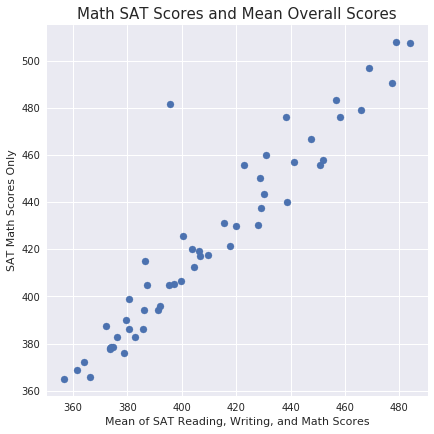

In [69]:
fig = plt.figure(figsize=(15,15)) 

ax1 = fig.add_subplot(221)
scatter = ax1.scatter(alldata['SATall'], alldata['SATmath'])
ax1.set_xlabel("Mean of SAT Reading, Writing, and Math Scores")
ax1.set_ylabel("SAT Math Scores Only")
ax1.set_title("Math SAT Scores and Mean Overall Scores", fontsize=15)

plt.show()

### Note on above plot:

We can see in the above plot that there is a strong positive, very linear correlation between average math SAT scores and the mean SAT scores across reading, writing, and math sections. This makes intuitive sense since students who perform poorly on one section of the SAT are unlikely to perform much better on another section of the test and vice versa. Instead, it is more likely that students who perform poorly on one section will have similarly low scores on other sections and students who perform well will have higher scores in each section.

### Plot of SAT against 3 crime features

In [70]:
alldata.rename(columns={'Major N':'Major_N', 'Oth N':'Oth_N', 'NoCrim N':'NoCrim_N', 'Prop N':'Prop_N', \
                        'Vio N':'Vio_N', 'AvgOfMajor N':'AvgOfMajor_N', 'AvgOfOth N':'AvgOfOth_N', \
                        'AvgOfNoCrim N':'AvgOfNoCrim_N', 'AvgOfProp N':'AvgOfProp_N', 'AvgOfVio N':'AvgOfVio_N'}\
              , inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


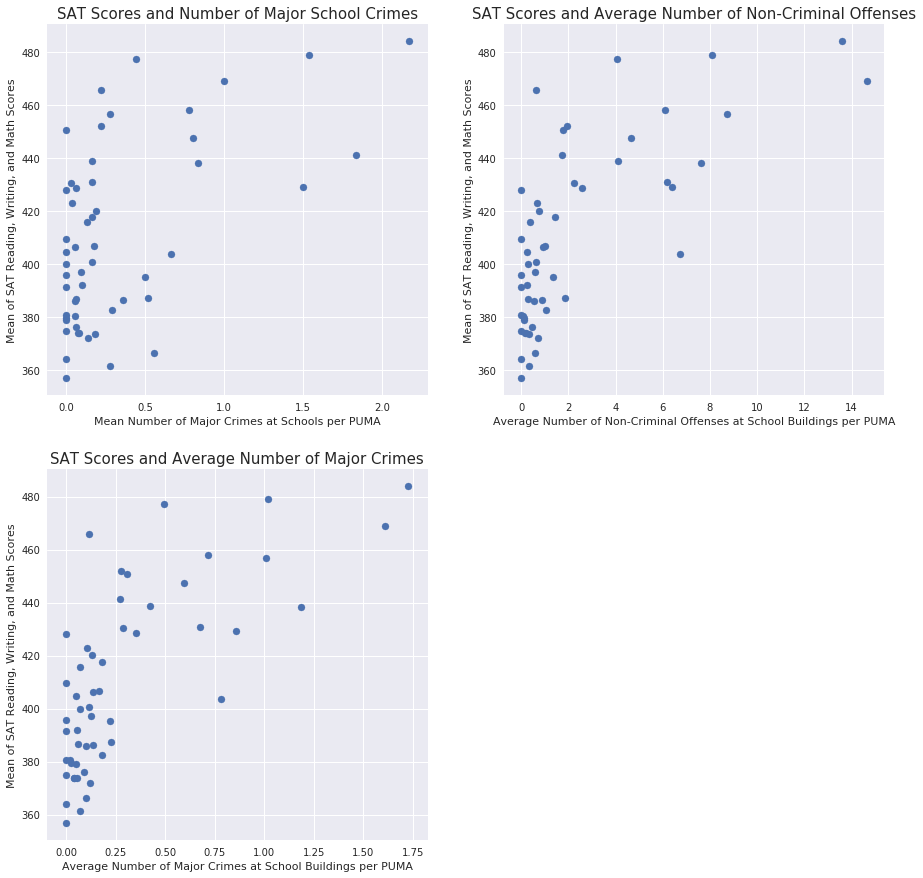

In [71]:
fig = plt.figure(figsize=(15,15)) 

ax1 = fig.add_subplot(221)
scatter = ax1.scatter(alldata['Major_N'], alldata['SATall'])
ax1.set_xlabel("Mean Number of Major Crimes at Schools per PUMA")
ax1.set_ylabel("Mean of SAT Reading, Writing, and Math Scores")
ax1.set_title("SAT Scores and Number of Major School Crimes", fontsize=15)

ax2 = fig.add_subplot(222)
scatter = ax2.scatter(alldata['AvgOfNoCrim_N'], alldata['SATall'])
ax2.set_xlabel("Average Number of Non-Criminal Offenses at School Buildings per PUMA")
ax2.set_ylabel("Mean of SAT Reading, Writing, and Math Scores")
ax2.set_title("SAT Scores and Average Number of Non-Criminal Offenses", fontsize=15)

ax3 = fig.add_subplot(223)
scatter = ax3.scatter(alldata['AvgOfMajor_N'], alldata['SATall'])
ax3.set_xlabel("Average Number of Major Crimes at School Buildings per PUMA")
ax3.set_ylabel("Mean of SAT Reading, Writing, and Math Scores")
ax3.set_title("SAT Scores and Average Number of Major Crimes", fontsize=15)

plt.show()

### Note on above plots:

The above plots show the mean SAT math and mean overall SAT scores against crime rates for schools in each PUMA. Interestingly, in each plot we see what appears to be a positive trend between SAT scores and each crime statistic. I expected to see the opposite trend: as crime increases, SAT scores would decrease. This may simply be a function of the size of schools rather than speaking more to the quality of the school. Larger schools are more likely to have higher crime rates. I would be curious to see if a trend exists between SAT scores and the size of schools.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


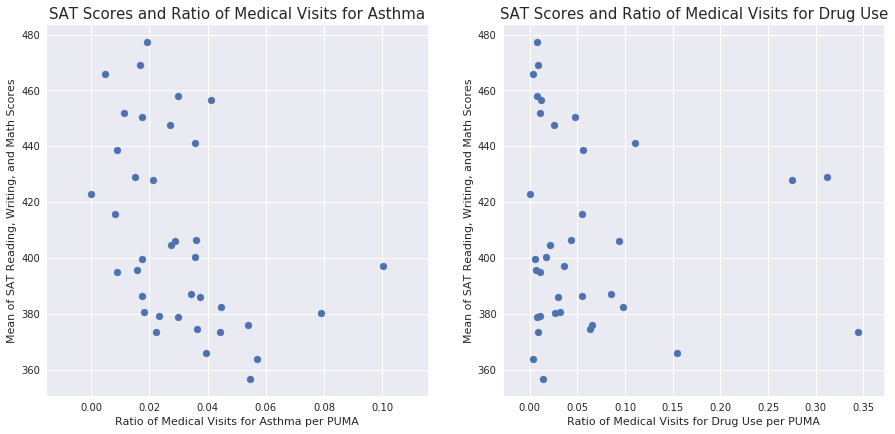

In [72]:
fig = plt.figure(figsize=(15,15)) 

ax1 = fig.add_subplot(221)
scatter = ax1.scatter(alldata['asthmaRatio'], alldata['SATall'])
ax1.set_xlabel("Ratio of Medical Visits for Asthma per PUMA")
ax1.set_ylabel("Mean of SAT Reading, Writing, and Math Scores")
ax1.set_title("SAT Scores and Ratio of Medical Visits for Asthma", fontsize=15)

ax2 = fig.add_subplot(222)
scatter = ax2.scatter(alldata['drugsRatio'], alldata['SATall'])
ax2.set_xlabel("Ratio of Medical Visits for Drug Use per PUMA")
ax2.set_ylabel("Mean of SAT Reading, Writing, and Math Scores")
ax2.set_title("SAT Scores and Ratio of Medical Visits for Drug Use", fontsize=15)

plt.show()

### Note on above plots:

The above plots show mean SAT scores against the rate of medical visits for asthma and drug use per PUMA. There appears to be a negative correlation between the ratio of medical visits related to asthma, which makes some intuitive sense. Neighborhoods with worse living conditions (heavy manufacturing, large thoroughfares, increased air pollution) would also seem more likely to have worse schools with fewer resources. SAT scores would therefore presumably drop due to these conditions.

The correlation between SAT scores and drug-related medical visits is less easy to discern, although I would have expected to see a negative correlation similar to the one seen between SAT scores and asthma.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


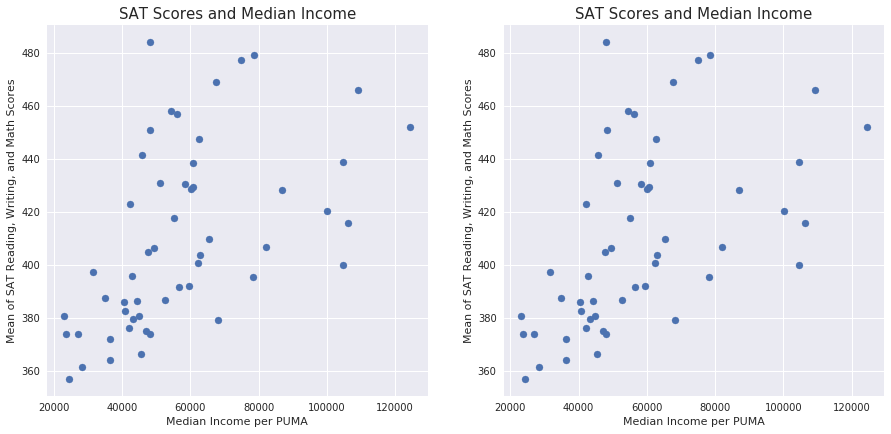

In [73]:
fig = plt.figure(figsize=(15,15)) 

ax1 = fig.add_subplot(221)
scatter = ax1.scatter(alldata['median_income'], alldata['SATall'])
ax1.set_xlabel("Median Income per PUMA")
ax1.set_ylabel("Mean of SAT Reading, Writing, and Math Scores")
ax1.set_title("SAT Scores and Median Income", fontsize=15)

ax2 = fig.add_subplot(222)
scatter = ax2.scatter(alldata['median_income'], alldata['SATall'])
ax2.set_xlabel("Median Income per PUMA")
ax2.set_ylabel("Mean of SAT Reading, Writing, and Math Scores")
ax2.set_title("SAT Scores and Median Income", fontsize=15)

plt.show()

### Notes on above plots:

The above plots show SAT scores as a function of the median income per PUMA. Here we can see a clear positive correlation between the two, which makes sense since neighborhoods with higher incomes will likely have schools with more resources, leading to higher SAT scores among their students.

### Covariance matrix

Here I plotted the covariance matrix to look for collinearity between variables.

In [74]:
corr = alldata.corr()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'Covariance Matrix')

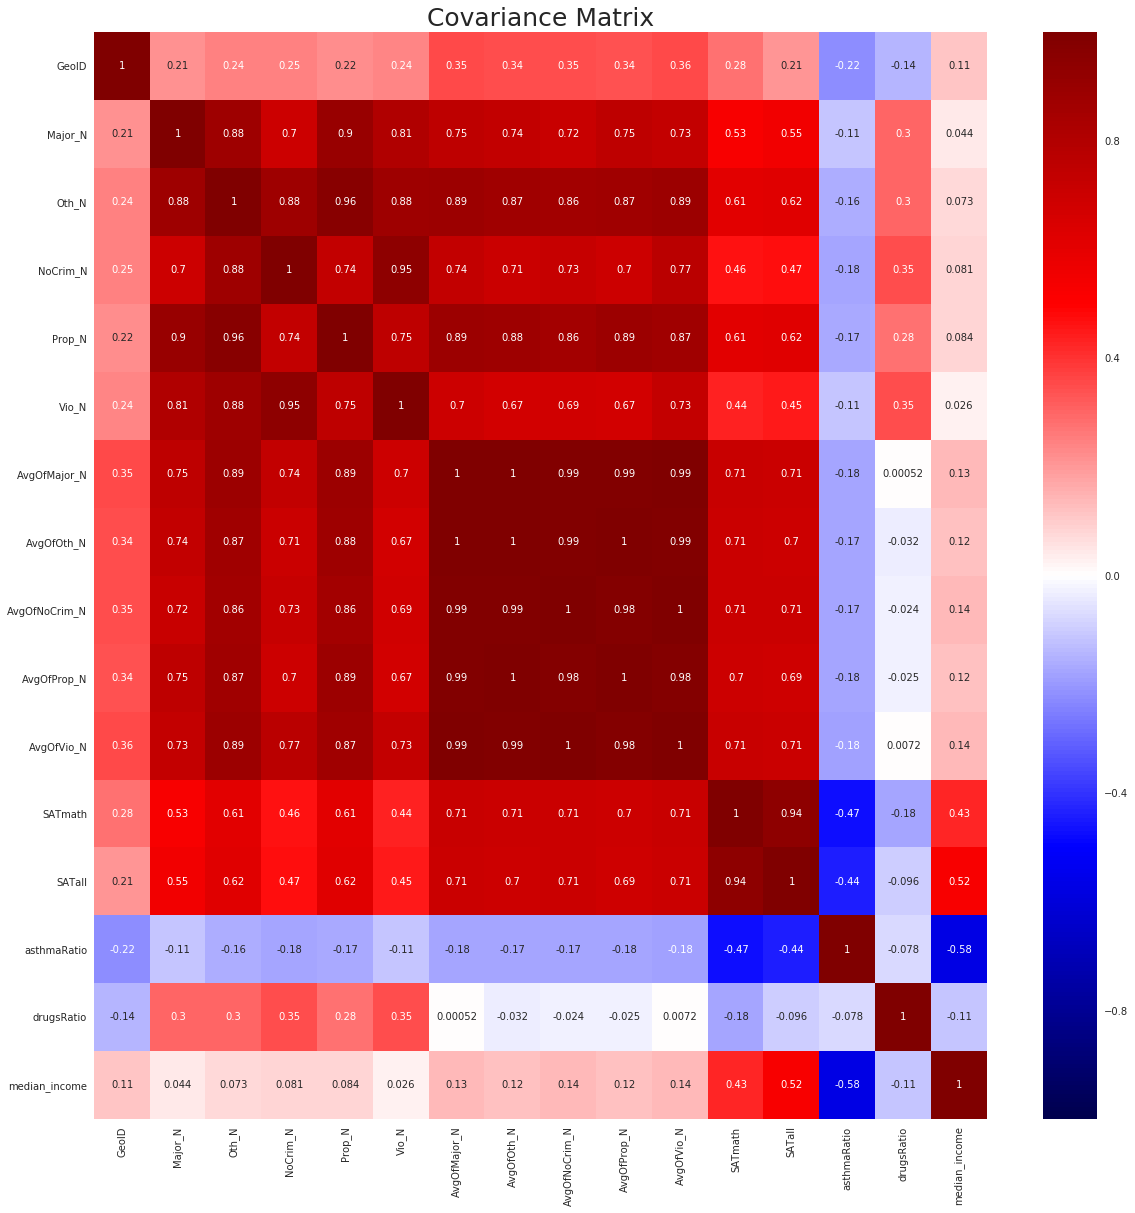

In [75]:
plt.figure(figsize = (20, 20))
sns.heatmap(corr, xticklabels=corr.columns.values, \
            yticklabels=corr.columns.values, cmap='seismic', annot=True)
plt.xticks(rotation='vertical')
plt.title('Covariance Matrix', fontsize=25)

### Note on above plot:

The covariance matrix above shows the correlations between variables in the combined data set of SAT performance, crimes committed at schools, medical visits, and median income. In the plot we can see highly positive correlations between the various crime categories, which makes sense. One would expect that schools with high rates of one type of crime, whether it is major crimes or violent crimes, will likely have higher rates of crimes in other categories. 

Interestingly, we see strong negative correlations between asthma and SAT scores and between median income and asthma visits. The correlation between asthma and SAT scores was previously visualized but the relationship between asthma and income has not already been analyzed here. But the same explanation that applies to SAT scores and asthma visits probably applies to income and asthma: neighborhoods with higher incomes are likely to have less heavy manufacturing and are probably located further away from large highways with many cars and worse air pollution.

## Mapping

In [76]:
pumashp_merge = pumashp.merge(alldata, how='outer', on='GeoID')

### SAT features

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


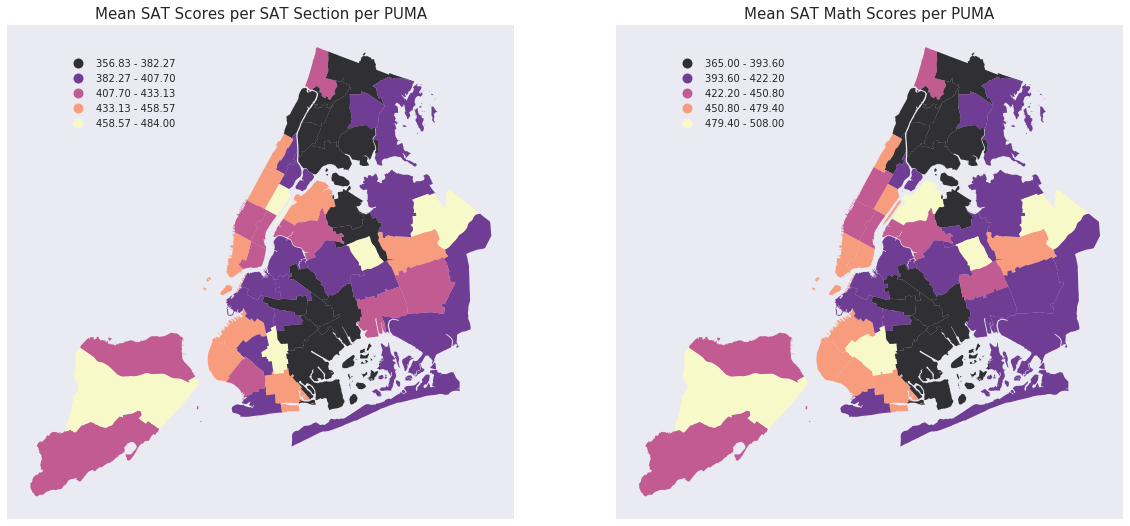

In [77]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(221)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
pumashp_merge.plot(column="SATall", alpha=.8, linewidth=0.5, ax=ax1, scheme="equal_interval", k=5, legend=True, \
             cmap=plt.cm.get_cmap('magma'))
leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
ax1.set_title("Mean SAT Scores per SAT Section per PUMA", fontsize=15)

ax2 = fig.add_subplot(222)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
pumashp_merge.plot(column="SATmath", alpha=.8, linewidth=0.5, ax=ax2, scheme="equal_interval", k=5, legend=True, \
             cmap=plt.cm.get_cmap('magma'))
leg = ax2.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
ax2.set_title("Mean SAT Math Scores per PUMA", fontsize=15)

plt.show()

### Note on above plots:

The above plots show mean SAT scores per PUMA. The Bronx and parts of southeast Brooklyn have the lowest mean SAT scores in the city, which closely matches the distribution of median income in the city's PUMAs. The comparison between income and SAT scores, however, does not hold up for neighborhoods with the highest mean SAT scores. We can see in the plot that schools in Manhattan have good but not the best mean SAT scores while those neighborhoods also have the highest median income. Instead, middle-income neighborhoods in Staten Island and Queens have the best SAT performance. Therefore, we cannot rely solely on median income to predict how students in a given neighborhood will perform on the SAT.

### School Crime Features

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


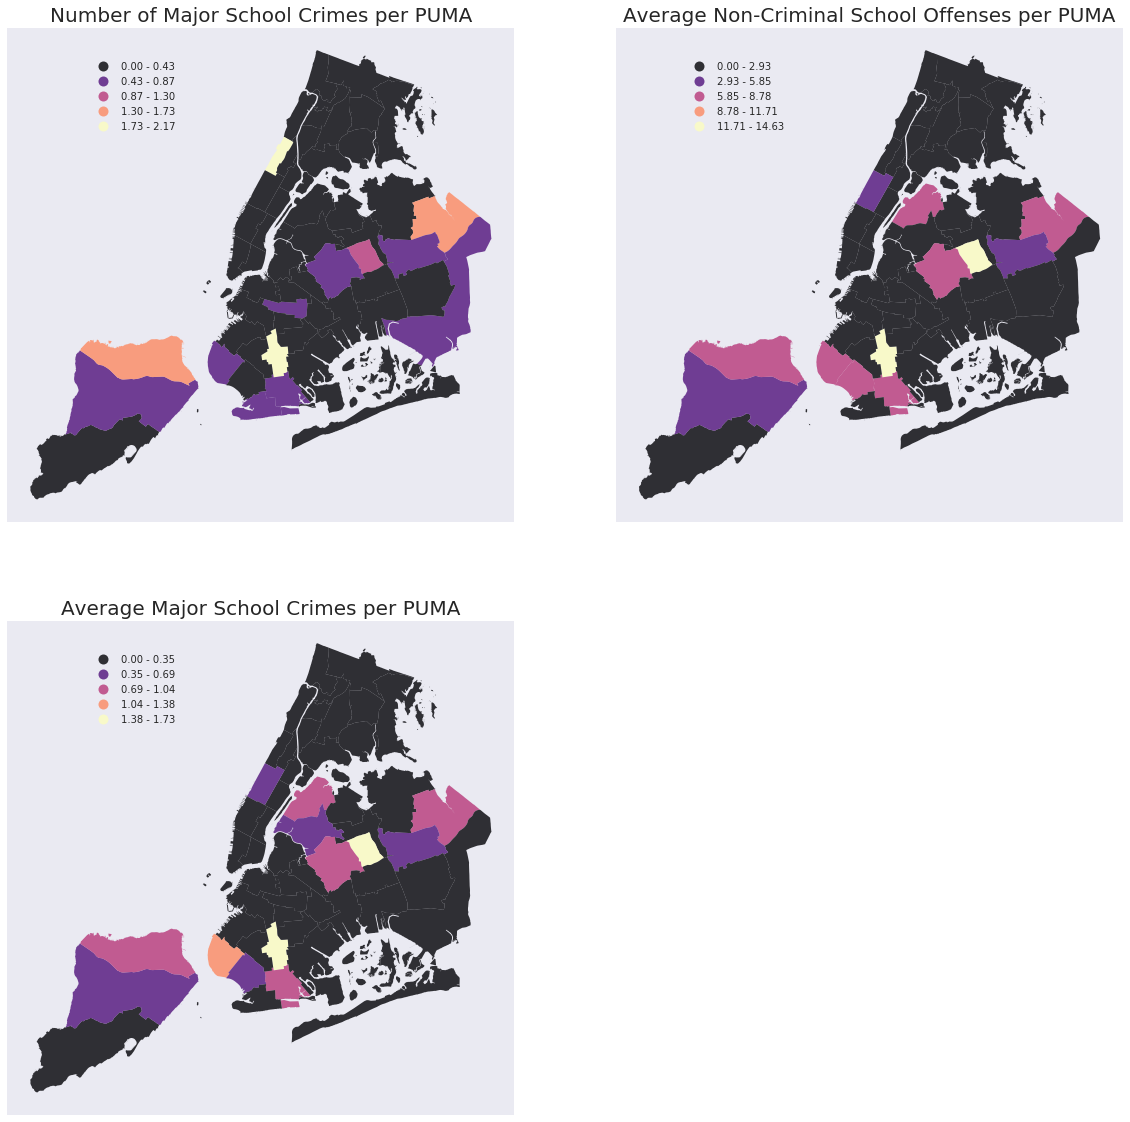

In [78]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(221)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
pumashp_merge.plot(column="Major_N", alpha=.8, linewidth=0.5, ax=ax1, scheme="equal_interval", k=5, legend=True, \
             cmap=plt.cm.get_cmap('magma'))
leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
ax1.set_title("Number of Major School Crimes per PUMA", fontsize=20)

ax2 = fig.add_subplot(222)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
pumashp_merge.plot(column="AvgOfNoCrim_N", alpha=.8, linewidth=0.5, ax=ax2, scheme="equal_interval", k=5, legend=True, \
             cmap=plt.cm.get_cmap('magma'))
leg = ax2.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
ax2.set_title("Average Non-Criminal School Offenses per PUMA", fontsize=20)

ax3 = fig.add_subplot(223)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
pumashp_merge.plot(column="AvgOfMajor_N", alpha=.8, linewidth=0.5, ax=ax3, scheme="equal_interval", k=5, legend=True, \
             cmap=plt.cm.get_cmap('magma'))
leg = ax3.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
ax3.set_title("Average Major School Crimes per PUMA", fontsize=20)

plt.show()

### Note on above plots:

The above plots show the means for various measures of offenses committed at schools per PUMA. We can see clear overlap in the neighborhoods with higher crime rates, which makes sense given the covariance matrix previously plotted, which showed a strong positive correlation between different measures of crime. Interestingly, neighborhoods with lower SAT scores have relatively lower crime rates. This is also confirmed by previous scatter plots, which showed a positive correlation between crime rates and SAT performance.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


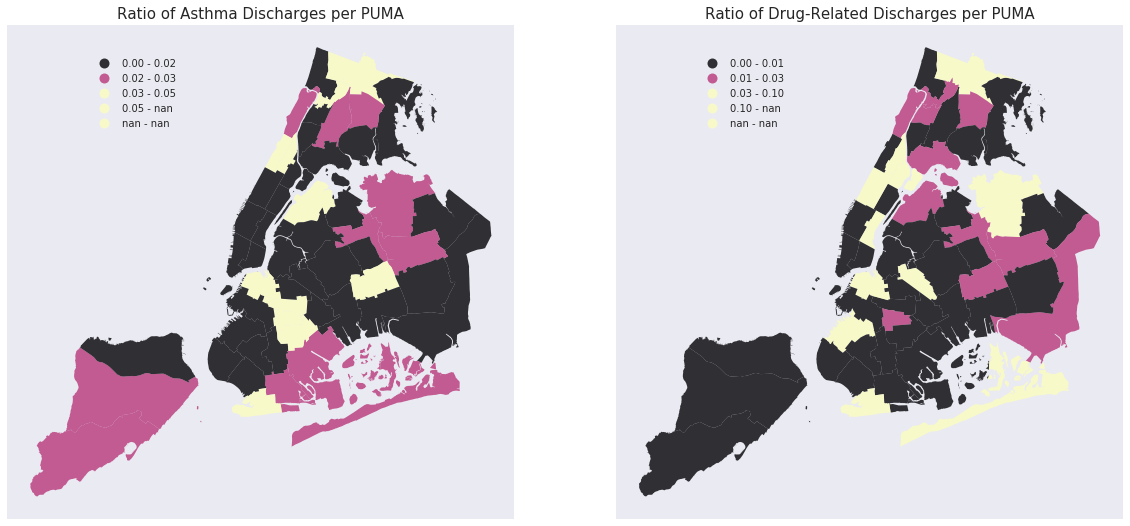

In [79]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(221)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
pumashp_merge.plot(column="asthmaRatio", alpha=.8, linewidth=0.5, ax=ax1, scheme="quantiles", legend=True, \
             cmap=plt.cm.get_cmap('magma'))
leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
ax1.set_title("Ratio of Asthma Discharges per PUMA", fontsize=15)

ax2 = fig.add_subplot(222)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
pumashp_merge.plot(column="drugsRatio", alpha=.8, linewidth=0.5, ax=ax2, scheme="quantiles", legend=True, \
             cmap=plt.cm.get_cmap('magma'))
leg = ax2.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
ax2.set_title("Ratio of Drug-Related Discharges per PUMA", fontsize=15)

plt.show()

### Note on above plots:

The above plots show where NYC PUMAs have lower and higher medical visits for asthma and drug-related conditions. We see some overlap between the two in north Manhattan and the Bronx but there are significant differences between the two in other parts of the city, especially Brooklyn and Staten Island. It is difficult to tell exactly what factors predict these two distributions, however, as they do not exactly track income, for example, and are relatively scattered rather than smooth. Specific structural factors may be more likely to explain the distribution of asthma and drug-related medical visits.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


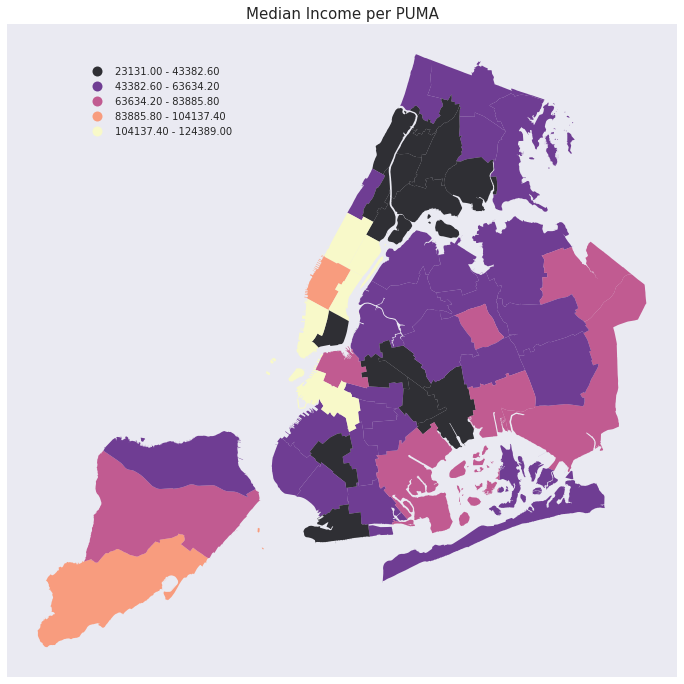

In [80]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(111)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
pumashp_merge.plot(column="median_income", alpha=.8, linewidth=0.5, ax=ax1, scheme="equal_interval", k=5, legend=True, \
             cmap=plt.cm.get_cmap('magma'))
leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
ax1.set_title("Median Income per PUMA", fontsize=15)

plt.show()

### Note on above plot:

The above plot shows median income per PUMA in NYC. Trends in income distribution generally follow anecdotal observations, namely that higher income families live primarily in Manhattan, which is the center of many industries and high-paying jobs. Interestingly, median income drops sharply for neighborhoods near the wealthiest parts of Manhattan. Median income then rises in parts of the city that are mroe suburban and farther away from the city center.

## Linear Models

### Multivariate model

In [81]:
cols_standard = list(alldata.columns.values)

In [82]:
# Dropped nans because standardization wouldn't run without doing so
alldata.dropna(inplace=True)

In [83]:
# Standardizing/whitening data
scaler = preprocessing.StandardScaler().fit(alldata[cols_standard])
data = scaler.transform(alldata[cols_standard])

In [84]:
standardized_alldata = pd.DataFrame(data=data, columns=cols_standard)
standardized_alldata.head()

,GeoID,Major_N,Oth_N,NoCrim_N,Prop_N,Vio_N,AvgOfMajor_N,AvgOfOth_N,AvgOfNoCrim_N,AvgOfProp_N,AvgOfVio_N,SATmath,SATall,asthmaRatio,drugsRatio,median_income
0,-1.540597,-0.68763,-0.658053,-0.616377,-0.645605,-0.655086,-0.704874,-0.630454,-0.609467,-0.654933,-0.675083,-1.105239,-0.998394,0.313133,0.058386,-0.446190
1,-1.526659,-0.68763,-0.089586,-0.392254,-0.189084,-0.096640,-0.560008,-0.514197,-0.519188,-0.524518,-0.543103,-0.229678,-0.109040,-0.138621,-0.445099,-0.426945
2,-1.519689,-0.24298,-0.176811,-0.114496,-0.322812,-0.050103,-0.536141,-0.498098,-0.503735,-0.507206,-0.522612,-1.113795,-1.031476,-0.404635,3.443848,-1.373146
3,-1.505751,-0.68763,-0.658053,-0.616377,-0.645605,-0.655086,-0.704874,-0.630454,-0.609467,-0.654933,-0.675083,-1.453181,-1.531565,1.207897,-0.540607,-1.344458
4,-1.491812,-0.68763,-0.658053,-0.616377,-0.645605,-0.655086,-0.704874,-0.630454,-0.609467,-0.654933,-0.675083,-1.267089,-1.314878,1.335167,-0.659997,-0.870113


In [85]:
# OLS math only
ols_math = smf.ols(formula = 'SATmath ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N + AvgOfOth_N \
            + AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N', data = alldata).fit()
ols_math.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     2.520
Date:                Thu, 14 Feb 2019   Prob (F-statistic):             0.0284
Time:                        19:04:40   Log-Likelihood:                -175.48
No. Observations:                  37   AIC:                             373.0
Df Residuals:                      26   BIC:                             390.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       400.9498      9.075     44.181      0.000       382.296   419.604
Major_N          84.9605     68.224      1.245      0.224       -55.275   225.196
Oth_N            48.0870     52.453      0.917      0.368       -59.731   155.905
NoCrim_N          0.0005      8.972   5.93e-05      1.000       -18.442    18.444
Prop_N          -69.5444     58.006     -1.199      0.241      -188.777    49.688
Vio_N           -70.5820     64.284     -1.098      0.282      -202.720    61.556
AvgOfMajor_N   -131.3059    869.208     -0.151      0.881     -1917.988  1655.376
AvgOfOth_N       31.8516    362.998      0.088      0.931      -714.302   778.005
AvgOfNoCrim_N   -32.0512     53.282     -0.602      0.553      -141.573    77.471
AvgOfProp_N     -49.7361    535.080     -0.093      0.927     -1149.609  1050.137
AvgOfVio_N      271.2597    483.404      0.561      0.580      -722.392  1264.912
==============================================================================
Omnibus:                        8.491   Durbin-Watson:                   1.587
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                7.198
Skew:                           0.939   Prob(JB):                       0.0273
Kurtosis:                       4.068   Cond. No.                     1.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
# OLS mean SAT section score
ols_all = smf.ols(formula = 'SATall ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N + AvgOfOth_N \
            + AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N', data = alldata).fit()
ols_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     3.465
Date:                Thu, 14 Feb 2019   Prob (F-statistic):            0.00524
Time:                        19:04:40   Log-Likelihood:                -166.85
No. Observations:                  37   AIC:                             355.7
Df Residuals:                      26   BIC:                             373.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       385.6200      7.189     53.643      0.000       370.843   400.397
Major_N          85.4329     54.042      1.581      0.126       -25.653   196.519
Oth_N            43.8203     41.550      1.055      0.301       -41.586   129.227
NoCrim_N          2.6106      7.107      0.367      0.716       -11.999    17.220
Prop_N          -67.1915     45.948     -1.462      0.156      -161.640    27.257
Vio_N           -71.3021     50.922     -1.400      0.173      -175.973    33.369
AvgOfMajor_N     98.5328    688.530      0.143      0.887     -1316.762  1513.827
AvgOfOth_N      -16.7165    287.544     -0.058      0.954      -607.771   574.338
AvgOfNoCrim_N   -26.0021     42.206     -0.616      0.543      -112.758    60.754
AvgOfProp_N      26.3544    423.856      0.062      0.951      -844.894   897.603
AvgOfVio_N      123.4057    382.922      0.322      0.750      -663.702   910.513
==============================================================================
Omnibus:                        8.655   Durbin-Watson:                   1.301
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                7.392
Skew:                           0.948   Prob(JB):                       0.0248
Kurtosis:                       4.097   Cond. No.                     1.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Note on regressions:

While each regression may have a relatively high R squared value, we could improve on these models since there is significant collinearity between predictor variables. As previously seen in the covariance matrix, different measures of crime are highly correlated with each other and it is therefore redundant to include so many crime measures in the model. The model would improve in terms of simplicity by removing several of these variables. 

Also, every independent variable in both models has a very high p value and therefore would not be accepted using most commonly-used alpha levels.

### Multivariate model with discharge data and income

In [87]:
# OLS math only no income
ols_math_dis = smf.ols(formula = 'SATmath ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N + AvgOfOth_N \
            + AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N + asthmaRatio + drugsRatio', data = alldata).fit()
ols_math_dis.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     4.028
Date:                Thu, 14 Feb 2019   Prob (F-statistic):            0.00179
Time:                        19:04:40   Log-Likelihood:                -167.60
No. Observations:                  37   AIC:                             361.2
Df Residuals:                      24   BIC:                             382.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       432.1387     11.645     37.111      0.000       408.106   456.172
Major_N          95.3299     57.606      1.655      0.111       -23.563   214.223
Oth_N            71.2221     44.761      1.591      0.125       -21.161   163.605
NoCrim_N         -3.6816      7.625     -0.483      0.634       -19.418    12.055
Prop_N          -85.1190     49.032     -1.736      0.095      -186.316    16.079
Vio_N           -80.9003     54.379     -1.488      0.150      -193.133    31.333
AvgOfMajor_N   -124.8457    750.039     -0.166      0.869     -1672.850  1423.158
AvgOfOth_N      -19.9266    310.824     -0.064      0.949      -661.436   621.583
AvgOfNoCrim_N   -17.6066     45.670     -0.386      0.703      -111.865    76.652
AvgOfProp_N      18.4829    456.797      0.040      0.968      -924.300   961.266
AvgOfVio_N      206.1836    413.578      0.499      0.623      -647.399  1059.766
asthmaRatio    -788.8154    239.736     -3.290      0.003     -1283.607  -294.024
drugsRatio     -104.8893     68.671     -1.527      0.140      -246.620    36.841
==============================================================================
Omnibus:                        6.346   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                4.976
Skew:                           0.844   Prob(JB):                       0.0831
Kurtosis:                       3.617   Cond. No.                     1.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
# OLS mean SAT section score no income
ols_all_dis = smf.ols(formula = 'SATall ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N + AvgOfOth_N \
            + AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N + asthmaRatio + drugsRatio', data = alldata).fit()
ols_all_dis.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     4.531
Date:                Thu, 14 Feb 2019   Prob (F-statistic):           0.000807
Time:                        19:04:40   Log-Likelihood:                -160.63
No. Observations:                  37   AIC:                             347.3
Df Residuals:                      24   BIC:                             368.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       407.1830      9.645     42.219      0.000       387.277   427.089
Major_N          90.8454     47.712      1.904      0.069        -7.628   189.319
Oth_N            58.3324     37.074      1.573      0.129       -18.184   134.849
NoCrim_N         -0.1352      6.315     -0.021      0.983       -13.169    12.899
Prop_N          -77.2800     40.611     -1.903      0.069      -161.097     6.537
Vio_N           -76.2257     45.040     -1.692      0.104      -169.183    16.732
AvgOfMajor_N    184.0352    621.220      0.296      0.770     -1098.100  1466.171
AvgOfOth_N      -26.0988    257.440     -0.101      0.920      -557.429   505.232
AvgOfNoCrim_N   -19.5608     37.826     -0.517      0.610       -97.631    58.509
AvgOfProp_N      38.0555    378.342      0.101      0.921      -742.805   818.916
AvgOfVio_N       42.0661    342.546      0.123      0.903      -664.914   749.046
asthmaRatio    -602.0651    198.562     -3.032      0.006     -1011.876  -192.254
drugsRatio      -43.9269     56.877     -0.772      0.447      -161.315    73.462
==============================================================================
Omnibus:                        6.783   Durbin-Watson:                   1.259
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                5.325
Skew:                           0.819   Prob(JB):                       0.0698
Kurtosis:                       3.877   Cond. No.                     1.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Note on models:

Although the R squared values in these models have improved since the previous models, this is still not necessarily an overall improvement. This model relies on many collinear independent variables, all of which have very high p values. Overall, it appears that we have a model that is highly overfit.

The most useful independent variable we see in the model is the ratio of medical visits related to asthma due to its  low p value.

In [89]:
# OLS math only with income
ols_math_dis_inc = smf.ols(formula = 'SATmath ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N + ' \
    'AvgOfOth_N + AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N + asthmaRatio + drugsRatio + median_income',\
                       data = alldata).fit()
ols_math_dis_inc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     4.260
Date:                Thu, 14 Feb 2019   Prob (F-statistic):            0.00122
Time:                        19:04:40   Log-Likelihood:                -165.33
No. Observations:                  37   AIC:                             358.7
Df Residuals:                      23   BIC:                             381.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       396.5598     23.381     16.961      0.000       348.193   444.926
Major_N          93.4514     55.353      1.688      0.105       -21.056   207.959
Oth_N            80.7921     43.356      1.863      0.075        -8.896   170.480
NoCrim_N         -9.6102      8.085     -1.189      0.247       -26.335     7.114
Prop_N          -90.7656     47.218     -1.922      0.067      -188.444     6.913
Vio_N           -77.5055     52.279     -1.483      0.152      -185.654    30.643
AvgOfMajor_N   -717.5878    797.628     -0.900      0.378     -2367.606   932.431
AvgOfOth_N      -54.8940    299.293     -0.183      0.856      -674.028   564.240
AvgOfNoCrim_N   -26.9672     44.207     -0.610      0.548      -118.416    64.482
AvgOfProp_N      59.4561    439.486      0.135      0.894      -849.689   968.602
AvgOfVio_N      589.2415    454.674      1.296      0.208      -351.323  1529.806
asthmaRatio    -437.0293    307.006     -1.424      0.168     -1072.121   198.062
drugsRatio      -92.2111     66.378     -1.389      0.178      -229.524    45.102
median_income     0.0005      0.000      1.733      0.096     -9.23e-05     0.001
==============================================================================
Omnibus:                       14.588   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.202
Skew:                           1.265   Prob(JB):                     0.000303
Kurtosis:                       5.027   Cond. No.                     1.44e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
# OLS mean SAT section score with income
ols_all_dis_inc = smf.ols(formula = 'SATall ~ Major_N + Oth_N + NoCrim_N + Prop_N + Vio_N + AvgOfMajor_N + ' \
    'AvgOfOth_N + AvgOfNoCrim_N + AvgOfProp_N + AvgOfVio_N + asthmaRatio + drugsRatio + median_income',\
                       data = alldata).fit()
ols_all_dis_inc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     7.845
Date:                Thu, 14 Feb 2019   Prob (F-statistic):           1.15e-05
Time:                        19:04:41   Log-Likelihood:                -151.21
No. Observations:                  37   AIC:                             330.4
Df Residuals:                      23   BIC:                             353.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       352.4046     15.961     22.078      0.000       319.386   385.423
Major_N          87.9532     37.789      2.328      0.029         9.781   166.125
Oth_N            73.0666     29.598      2.469      0.021        11.838   134.295
NoCrim_N         -9.2630      5.519     -1.678      0.107       -20.681     2.154
Prop_N          -85.9738     32.235     -2.667      0.014      -152.657   -19.291
Vio_N           -70.9990     35.690     -1.989      0.059      -144.830     2.832
AvgOfMajor_N   -728.5679    544.525     -1.338      0.194     -1855.003   397.867
AvgOfOth_N      -79.9357    204.321     -0.391      0.699      -502.606   342.735
AvgOfNoCrim_N   -33.9727     30.179     -1.126      0.272       -96.403    28.458
AvgOfProp_N     101.1390    300.028      0.337      0.739      -519.517   721.795
AvgOfVio_N      631.8333    310.397      2.036      0.053       -10.272  1273.938
asthmaRatio     -60.4448    209.587     -0.288      0.776      -494.009   373.119
drugsRatio      -24.4071     45.315     -0.539      0.595      -118.148    69.334
median_income     0.0007      0.000      3.908      0.001         0.000     0.001
==============================================================================
Omnibus:                        4.383   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                3.255
Skew:                           0.708   Prob(JB):                        0.196
Kurtosis:                       3.323   Cond. No.                     1.44e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Note on regression models:

Similar to the comment made on the previous models, although we have R squared values, this is to be expected since we are simply adding more explanatory variables to the model. Again, this is probably a case of overfitting the data. Interestingly, though, by adding median income to the model, the p values for several measures of school crime drop significantly while the p value for asthma rises significantly, which is likely due to collinearity between asthma and income. Based on this model, the best choice may be to create a model using only the number of property crimes and median income.

## Linear model comparison

In [91]:
# Math comparison
ols_math_dis.compare_lr_test(ols_math)

(15.747162470673288, 0.00038066865416289288, 2.0)

In [92]:
# Mean SAT section comparison
ols_all_dis.compare_lr_test(ols_all)

(12.44802009012642, 0.0019812842269351706, 2.0)

### Note on comparison:

By using the Likelihood Ratio test to compare the OLS model for SAT scores using only school crime measures to the model that also incorporates medical discharge data, we are led to conclude that the more complex model is better. We may draw this conclusion since the p values in each test are very low (.0004 and .002, which are significant at very low alpha levels). This aligns with the results seen in the OLS tables for each model, which showed improving R squared values and declining p values once medical discharge variables were added to the models.

In [93]:
# Income comparison for math
ols_math_dis_inc.compare_lr_test(ols_math)

(20.288010831537918, 0.00014793956753935704, 3.0)

In [94]:
# Income comparison for SAT all
ols_all_dis_inc.compare_lr_test(ols_all)

(31.292282017126468, 7.377229456228813e-07, 3.0)

### Note on comparison:

By using the Likelihood Ratio test to compare the OLS model for SAT scores using only school crime measures to the model that also incorporates medical discharge and income data, we are led to conclude that the more complex model is better. We may draw this conclusion since the p values in each test are very low (.0001 and 7.4e-07, which are significant at very low alpha levels). This aligns with the results seen in the OLS tables for each model, which showed improving R squared values and declining p values once medical discharge and income variables were added to the models.

Given the very low p values of median income and the number of property crimes. Since crime measures are highly collinear, it would make sense to eliminate some of these variables from the model to help prevent overfitting while retaining the one crime measure with the most significant result, which is the measure of property crimes.

## Random Forest regression

### Random Forest model using crime data

In [95]:
# Model for mean SAT section data
X1 = alldata[['Major_N', 'Oth_N', 'NoCrim_N', 'Prop_N', 'Vio_N', 'AvgOfMajor_N', 'AvgOfOth_N', 'AvgOfNoCrim_N', \
             'AvgOfProp_N', 'AvgOfVio_N']]
y1 = alldata['SATall']

In [96]:
numpy.random.seed(100)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33)

In [97]:
# Supervised transformation based on random forests
rf = rfc(max_depth=3, n_estimators=100)
rf.fit(X_train1, y_train1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [98]:
rf.score(X_train1, y_train1)

0.80278439430665494

In [99]:
rf.score(X_test1, y_test1)

0.77620400232733511

### Model performance:

Since the model performs slightly better on the training data than it does with the test data, we should conclude that the model is currently overfitted to the training data and should be revised. To improve the Random Forest regression, we might want to add trees to the forest or make other adjustments, such as tuning the number of parameters used by the model.

### Measuing feature importance

In [100]:
labels1 = ['Major_N', 'Oth_N', 'NoCrim_N', 'Prop_N', 'Vio_N', 'AvgOfMajor_N', 'AvgOfOth_N', 'AvgOfNoCrim_N', \
             'AvgOfProp_N', 'AvgOfVio_N']

In [101]:
# Visualizing feature importance
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)


    plt.figure()
    plt.title("Plot of Feature Importance")
    plt.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    plt.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    plt.xlim([-1, indices.shape[0]])
    plt.show()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


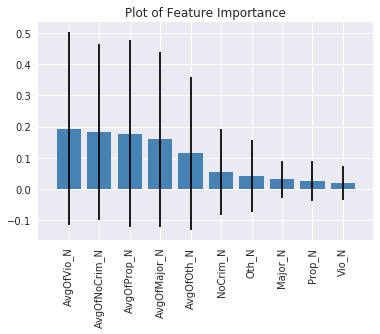

In [102]:
featureImportancePlot(rf, labels1)

### Note on feature importance:

Based on the feature importance measure above, the average number of violent crimes, average number of non criminal offenses, and average number of property crimes are the three most important features used by the Random Forest regression model.

## Modified random forest 

### Model with 3 most predictive crime categories plus health and income

In [103]:
X2 = alldata[['AvgOfVio_N', 'AvgOfNoCrim_N', 'AvgOfProp_N', 'asthmaRatio', 'drugsRatio', 'median_income']]
y2 = alldata['SATall']

In [104]:
numpy.random.seed(101)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33)

In [105]:
# Supervised transformation based on random forests
rf = rfc(max_depth=3, n_estimators=100)
rf.fit(X_train2, y_train2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Model performance

In [106]:
rf.score(X_train2, y_train2)

0.90694182968413162

In [107]:
rf.score(X_test2, y_test2)

0.4080650267367838

The revised model is even more overfit to the training data than it is to the test data. Unfortunately, our model revision has only made the problem worse.

### Discuss the importance of each feature

In [108]:
labels2 = ['AvgOfVio_N', 'AvgOfNoCrim_N', 'AvgOfProp_N', 'asthmaRatio', 'drugsRatio', 'median_income']

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


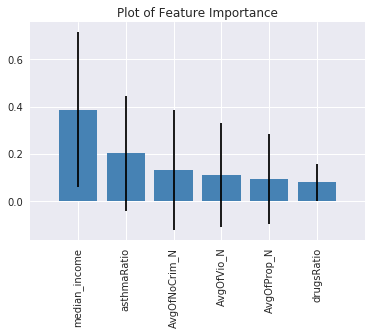

In [109]:
featureImportancePlot(rf, labels2)

Based on the feature importance measure above, median income and the ratio of medical visits related to asthma are the two most significant features in this Random Forest regression. This aligns with results previously seen in linear regression, where median income and asthma were two variables with relatively low p values compared to most of the variables for school crimes.